Type: Learning Project \
Author: Yash K

#### About: Resume Screening

Data set: \
Dataset has 2 columns: category and resume text (blob)

In [46]:
from sklearn import metrics
# ^^^ pyforest auto-imports - don't write above this line
#imports
import warnings
warnings.filterwarnings('ignore')
import string

#generic/data
import numpy as np
import pandas as pd
from scipy.sparse import hstack

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from wordcloud import WordCloud

#utility
import re
from tqdm.notebook import tqdm

#ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#NLP

import nltk
from nltk.corpus import stopwords

###### Load data and basic analysis

In [5]:
data = pd.read_csv('./resume-screening-dataset/UpdatedResumeDataSet.csv')

In [13]:
data.shape

(962, 2)

In [9]:
data.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [11]:
data.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [12]:
data.Category.value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

###### Visualization

<AxesSubplot:xlabel='count', ylabel='Category'>

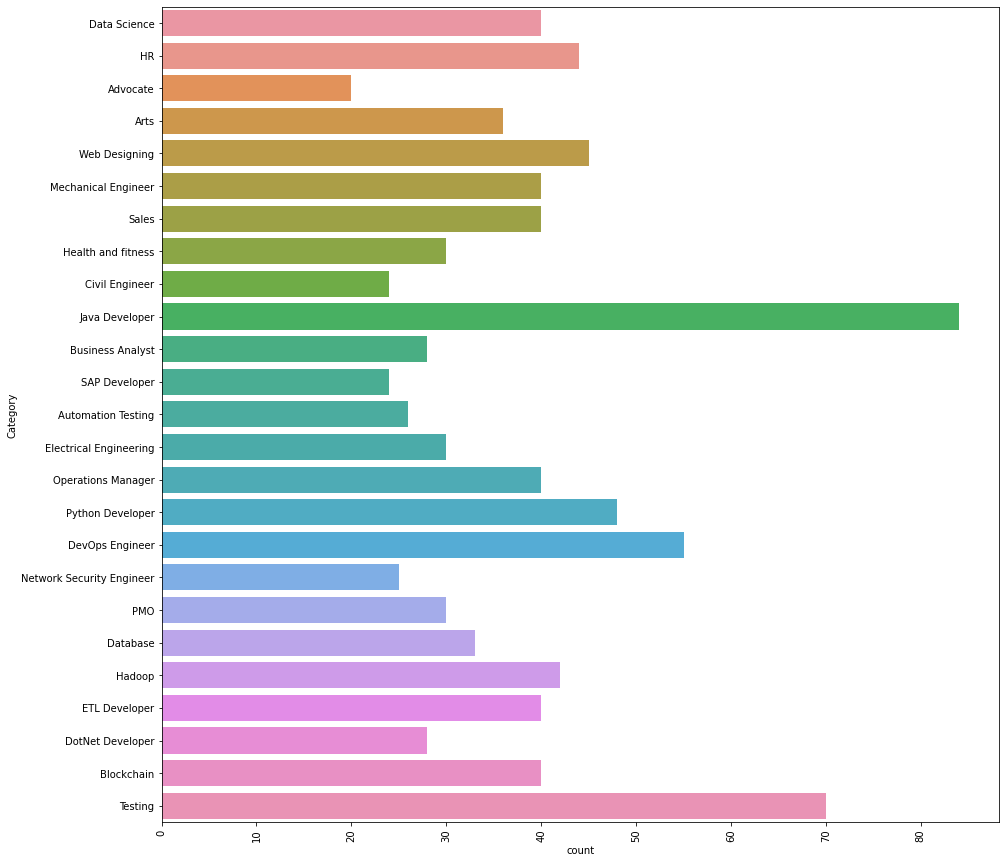

In [14]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y='Category', data=data)

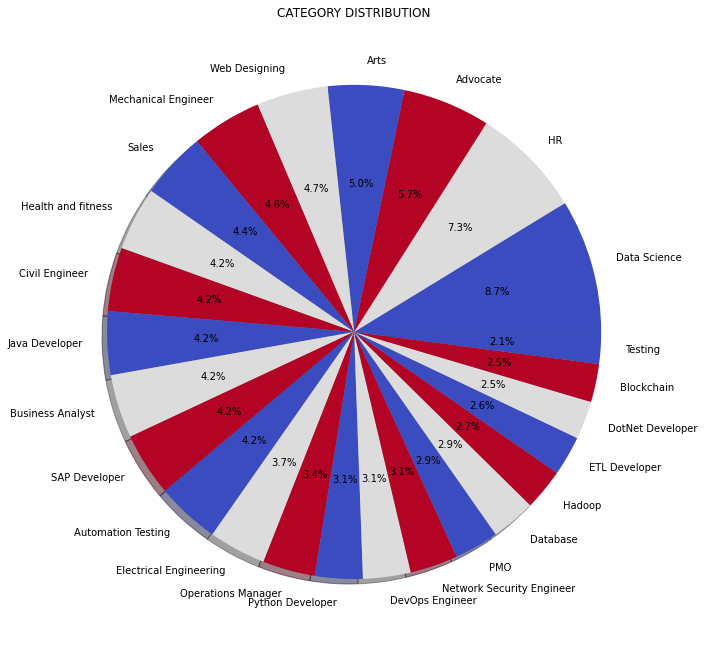

In [18]:
from matplotlib.gridspec import GridSpec
targetCounts = data['Category'].value_counts()
targetLabels = data['Category'].unique()

plt.figure(figsize=(25,25))
the_grid = GridSpec(2,2)

cmap = plt.get_cmap('coolwarm') #get color map
colors = [cmap(i) for i in np.linspace(0,1,3)]

plt.subplot(the_grid[0,1], aspect=1, title='CATEGORY DISTRIBUTION')
source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

###### cleaning up the data

In [19]:
#create a new column to save cleaned resume
data['cleanedResume']=''

In [20]:
data.head(1)

,Category,Resume,cleanedResume
0,Data Science,Skills * Programming Languages: Python (pandas...,


In [24]:
#helper function to remove puctuation, URLs, mentions, hashtags, special letters etc.
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespacere
    return resumeText

In [25]:
data.cleanedResume = data.Resume.apply(lambda x: cleanResume(x))

In [26]:
data.head()

,Category,Resume,cleanedResume
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


In [33]:
# nltk.download('punkt')

In [38]:
#create a wordcloud
oneSetOfStopwords = set(stopwords.words('english')+['``', "''"])
totalWords=[]

sentences = data.Resume.values
cleanedSentences=""

for i in range(len(sentences)):
    cleanedText = cleanResume(sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopwords and word not in string.punctuation:
            totalWords.append(word)

wordFreqDist = nltk.FreqDist(totalWords)
mostCommon = wordFreqDist.most_common(50)
print(mostCommon)

[('Exprience', 3829), ('months', 3233), ('company', 3130), ('Details', 2967), ('description', 2634), ('1', 2134), ('Project', 1808), ('project', 1579), ('6', 1499), ('data', 1438), ('team', 1424), ('Maharashtra', 1385), ('year', 1244), ('Less', 1137), ('January', 1086), ('using', 1041), ('Skill', 1018), ('Pune', 1016), ('Management', 1010), ('SQL', 990), ('Ltd', 934), ('management', 927), ('C', 896), ('Engineering', 855), ('Education', 833), ('Developer', 806), ('Java', 773), ('2', 754), ('development', 752), ('monthsCompany', 746), ('Pvt', 730), ('application', 727), ('System', 715), ('reports', 697), ('business', 696), ('India', 693), ('requirements', 693), ('I', 690), ('various', 688), ('A', 688), ('Data', 674), ('The', 672), ('University', 656), ('process', 648), ('Testing', 646), ('test', 638), ('Responsibilities', 637), ('system', 636), ('testing', 634), ('Software', 632)]


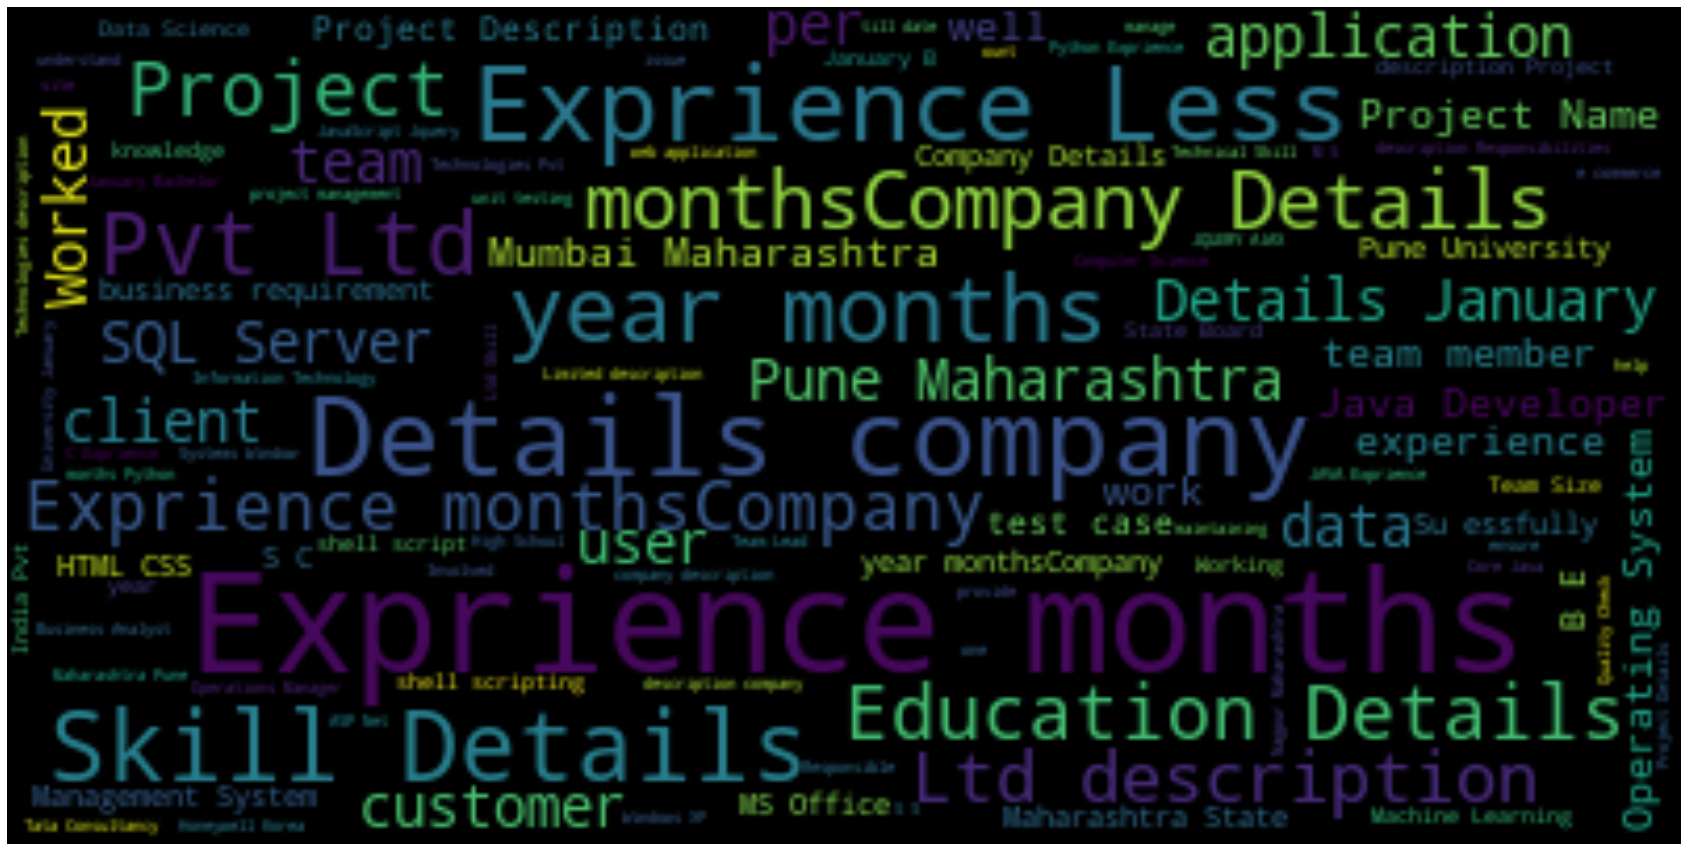

In [41]:
wc=WordCloud().generate(cleanedSentences)
plt.figure(figsize=(30,30))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
#convert category to categorical values
data.Category = LabelEncoder().fit_transform(data.Category)

In [45]:
data.head()

,Category,Resume,cleanedResume
0,6,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,6,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,6,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,6,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,6,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


##### Training ML Model

In [47]:
#using k-neighbours classifier
requiredText = data.cleanedResume.values
requiredTarget = data.Category.values

word_vectorizer = TfidfVectorizer(sublinear_tf=True, stop_words='english', max_features=1500)
word_vectorizer.fit(requiredText)

word_features = word_vectorizer.transform(requiredText)

In [49]:
X_train,X_test,y_train,y_test = train_test_split(word_features,requiredTarget,random_state=0, test_size=0.2)

In [51]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [52]:
print('Accuracy:', accuracy_score(y_test, prediction))

Accuracy: 0.9896373056994818


In [53]:
print('Classification report:')
print(metrics.classification_report(y_test, prediction))

Classification report:


<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00         3
          17       1.00    

In [54]:
print('Balanced Accuracy Score:', metrics.balanced_accuracy_score(y_test, prediction))

<IPython.core.display.Javascript object>

Balanced Accuracy Score: 0.9883636363636364
